In [1]:
# Fix pyarrow/pandas compatibility issue
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Core imports and paths
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import json
import joblib
from pathlib import Path

# Adjust these paths as needed
SEQ_PATH   = Path("artifacts/features/sequences/")
LABEL_PATH = Path("artifacts/labels/")
DENSE_PATH = Path("artifacts/features/dense/")

print("Environment ready.")

Environment ready.


In [3]:
# Load tokenized sequences (npz with 'arr_0')
X_train_seq = np.load(SEQ_PATH / "X_train_seq_v1.npz")["arr_0"]
X_valid_seq = np.load(SEQ_PATH / "X_valid_seq_v1.npz")["arr_0"]
X_test_seq  = np.load(SEQ_PATH / "X_test_seq_v1.npz")["arr_0"]

# Minimal sanity info
print(f"Seq shapes — train:{X_train_seq.shape}, valid:{X_valid_seq.shape}, test:{X_test_seq.shape}")
print(f"Max seq length: {X_train_seq.shape[1]}")


Seq shapes — train:(109816, 65), valid:(6102, 65), test:(6102, 65)
Max seq length: 65


In [4]:
# Basic sequence stats to spot edge cases
non_zero = np.count_nonzero(X_train_seq, axis=1)
print(f"Train non-pad length — mean:{non_zero.mean():.2f}, min:{non_zero.min()}, max:{non_zero.max()}")

# Token index upper bound (vocab cap used during sequencing)
print(f"Max token index in train: {int(X_train_seq.max())}")

Train non-pad length — mean:16.95, min:0, max:65
Max token index in train: 39999


In [5]:
# Reuse the exact tokenizer used for training
tokenizer = joblib.load(SEQ_PATH / "tokenizer_v1.joblib")

# Metadata (e.g., VOCAB_SIZE, MAX_LEN)
with open(SEQ_PATH / "sequence_meta_v1.txt", "r") as f:
    meta_txt = f.read()

print(f"Tokenizer size (unique indices): {len(tokenizer.word_index)}")
print("Meta:", meta_txt.strip().replace("\n", " | "))


2025-10-05 12:17:26.040491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tokenizer size (unique indices): 46273
Meta: VOCAB_SIZE=40000 | MAX_LEN=65


In [6]:
# Load label CSVs (single column with integer class IDs)
y_train = pd.read_csv(LABEL_PATH / "y_train_v1.csv")
y_valid = pd.read_csv(LABEL_PATH / "y_valid_v1.csv")
y_test  = pd.read_csv(LABEL_PATH / "y_test_v1.csv")

label_col = y_train.columns[0]
print(f"Label shapes — train:{y_train.shape}, valid:{y_valid.shape}, test:{y_test.shape}")

# Light class distribution (train only)
train_counts = y_train[label_col].value_counts().sort_index()
print("Train class counts:", train_counts.to_dict())

Label shapes — train:(109815, 1), valid:(6101, 1), test:(6101, 1)
Train class counts: {0: 14800, 1: 2174, 2: 3953, 3: 31351, 4: 36691, 5: 9130, 6: 11716}


In [7]:
# Mapping between emotion name and numeric ID
with open(LABEL_PATH / "label_mapping_v1.json", "r") as f:
    label_mapping = json.load(f)

# Make a reverse lookup for readability
id_to_emotion = {v: k for k, v in label_mapping.items()}

print("Classes:", {i: id_to_emotion[i] for i in sorted(id_to_emotion)})


Classes: {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [8]:
# Load engineered dense features and the scaler used at train time
dense_features = pd.read_parquet(DENSE_PATH / "dense_features_v1.parquet", engine="pyarrow")
with open(DENSE_PATH / "dense_feature_columns_v1.json", "r") as f:
    feature_columns = json.load(f)
scaler = joblib.load(DENSE_PATH / "dense_scaler_v1.joblib")

print(f"Dense features: {dense_features.shape}, n_cols={len(feature_columns)}")

Dense features: (122017, 22), n_cols=22


In [9]:
# If there is no explicit 'split' column, assume concatenated [train|valid|test] order
if "split" in dense_features.columns:
    train_dense = dense_features[dense_features["split"] == "train"][feature_columns]
    valid_dense = dense_features[dense_features["split"] == "valid"][feature_columns]
    test_dense  = dense_features[dense_features["split"] == "test"][feature_columns]
else:
    n_train, n_valid = len(y_train), len(y_valid)
    train_dense = dense_features.iloc[:n_train][feature_columns]
    valid_dense = dense_features.iloc[n_train:n_train+n_valid][feature_columns]
    test_dense  = dense_features.iloc[n_train+n_valid:][feature_columns]

print(f"Dense split — train:{train_dense.shape}, valid:{valid_dense.shape}, test:{test_dense.shape}")


Dense split — train:(109815, 22), valid:(6101, 22), test:(6101, 22)


In [10]:
# Check counts between sequences and labels
def _ok(x, y): return x == y
print("Seq/label match:",
      dict(train=_ok(X_train_seq.shape[0], len(y_train)),
           valid=_ok(X_valid_seq.shape[0], len(y_valid)),
           test=_ok(X_test_seq.shape[0], len(y_test))))

# If sequences have one extra row per split, trim tail to match labels
if X_train_seq.shape[0] != len(y_train):
    X_train_seq = X_train_seq[:len(y_train)]
if X_valid_seq.shape[0] != len(y_valid):
    X_valid_seq = X_valid_seq[:len(y_valid)]
if X_test_seq.shape[0]  != len(y_test):
    X_test_seq  = X_test_seq[:len(y_test)]

print(f"Post-fix shapes — train:{X_train_seq.shape}, valid:{X_valid_seq.shape}, test:{X_test_seq.shape}")


Seq/label match: {'train': False, 'valid': False, 'test': False}
Post-fix shapes — train:(109815, 65), valid:(6101, 65), test:(6101, 65)


In [11]:
# Remove rows with 0 effective tokens (all pads) from TRAIN ONLY to avoid noise
train_nonempty_mask = np.count_nonzero(X_train_seq, axis=1) > 0
X_train_seq = X_train_seq[train_nonempty_mask]
y_train = y_train.loc[train_nonempty_mask].reset_index(drop=True)
train_dense = train_dense.loc[train_nonempty_mask].reset_index(drop=True)

print(f"Train after removing empties: {X_train_seq.shape}, labels:{y_train.shape}, dense:{train_dense.shape}")


Train after removing empties: (109811, 65), labels:(109811, 1), dense:(109811, 22)


In [12]:
# Load external test CSV with text and emotion labels
new_test_data = pd.read_csv("group_8_url_1_transcript.csv")

# Use the same language as training; your tokenizer indicates English
TEXT_COLUMN = "Translation"  # change to 'Sentence' if you actually trained on Arabic
print(f"External samples: {len(new_test_data)}, text column: '{TEXT_COLUMN}'")

External samples: 5994, text column: 'Translation'


In [13]:
# Load external test CSV with text and emotion labels
new_test_data = pd.read_csv("group_8_url_1_transcript.csv")

# Use the same language as training; your tokenizer indicates English
TEXT_COLUMN = "Translation"  # change to 'Sentence' if you actually trained on Arabic
print(f"External samples: {len(new_test_data)}, text column: '{TEXT_COLUMN}'")


External samples: 5994, text column: 'Translation'


In [14]:
# Show sample of each column to identify which contains text
print("Sample data from each column:\n")
for col in new_test_data.columns:
    print(f"\n{col}:")
    print(new_test_data[col].head(3))
    print("-" * 50)

Sample data from each column:


Start Time:
0    1900-01-01 00:00:00
1    1900-01-01 00:00:02
2    1900-01-01 00:00:04
Name: Start Time, dtype: object
--------------------------------------------------

End Time:
0    1900-01-01 00:00:02
1    1900-01-01 00:00:04
2    1900-01-01 00:00:05
Name: End Time, dtype: object
--------------------------------------------------

Sentence:
0    لا يوجد علاقة بدون حاجة
1                      قاعدة
2              لا يوجد علاقة
Name: Sentence, dtype: object
--------------------------------------------------

Translation:
0    There is no relationship without need
1                                     Base
2                 There is no relationship
Name: Translation, dtype: object
--------------------------------------------------

Emotion_fine:
0    resignation
1     neutrality
2     detachment
Name: Emotion_fine, dtype: object
--------------------------------------------------

Emotion_core:
0    neutral
1    neutral
2    neutral
Name: Emotion_core, 

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert raw text to sequences using the training tokenizer
test_texts = new_test_data[TEXT_COLUMN].fillna("").astype(str).tolist()
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad/truncate to the training max length
SEQ_LEN = X_train_seq.shape[1]
X_new_test = pad_sequences(test_sequences, maxlen=SEQ_LEN, padding="post", truncating="post")

print(f"External tokenized shape: {X_new_test.shape} (seq_len={SEQ_LEN})")


External tokenized shape: (5994, 65) (seq_len=65)


In [16]:
# The external file includes fine-grained and core emotions; map the core ones to your 7-class set
if set(new_test_data.get("Emotion_core", [])).issubset(set(label_mapping.keys())):
    EMOTION_COL = "Emotion_core"
elif set(new_test_data.get("Emotion_fine", [])).issubset(set(label_mapping.keys())):
    EMOTION_COL = "Emotion_fine"
else:
    # Default to core; if there are unknowns, they’ll be flagged below
    EMOTION_COL = "Emotion_core"

# Convert emotion strings to numeric IDs (unknowns -> -1)
y_new_test = []
for emo in new_test_data[EMOTION_COL].astype(str):
    y_new_test.append(label_mapping.get(emo, -1))
y_new_test = np.array(y_new_test, dtype=int)

valid_mask = y_new_test >= 0
X_new_test_valid = X_new_test[valid_mask]
y_new_test_valid = y_new_test[valid_mask]

print(f"External labels: total={len(y_new_test)}, valid={valid_mask.sum()}, unknown={(~valid_mask).sum()}")
print(f"Emotion column used: {EMOTION_COL}")


External labels: total=5994, valid=5994, unknown=0
Emotion column used: Emotion_core


In [17]:
# Compact one-liner summaries to keep the notebook quiet but informative
summary = {
    "train_seq": X_train_seq.shape,
    "valid_seq": X_valid_seq.shape,
    "test_seq":  X_test_seq.shape,
    "dense_cols": len(feature_columns),
    "new_test_seq": X_new_test.shape,
    "new_test_valid": X_new_test_valid.shape[0],
    "n_classes": len(label_mapping),
}
summary


{'train_seq': (109811, 65),
 'valid_seq': (6101, 65),
 'test_seq': (6101, 65),
 'dense_cols': 22,
 'new_test_seq': (5994, 65),
 'new_test_valid': 5994,
 'n_classes': 7}

In [18]:
# Save external test set artifacts for later prediction/evaluation
new_test_data.assign(
    is_valid=valid_mask,
    numeric_label=y_new_test
).to_csv("test_data_prepared.csv", index=False)

np.savez_compressed("X_new_test.npz", X_new_test_valid)
np.save("y_new_test.npy", y_new_test_valid)

print("Saved: test_data_prepared.csv, X_new_test.npz, y_new_test.npy")


Saved: test_data_prepared.csv, X_new_test.npz, y_new_test.npy


In [19]:
# Example usage after you load your trained model:
# predictions = model.predict({"tokens": X_new_test_valid, "dense": scaled_dense_if_used})
# from sklearn.metrics import classification_report
# pred_labels = predictions.argmax(axis=1)
# print(classification_report(y_new_test_valid, pred_labels, target_names=[id_to_emotion[i] for i in range(len(label_mapping))]))
print("Ready for prediction/evaluation. (See commented example.)")


Ready for prediction/evaluation. (See commented example.)


In [21]:
# Convenience
ytr = y_train[label_col].astype(int).values
yva = y_valid[label_col].astype(int).values
yte = y_test[label_col].astype(int).values

def dist(y, name):
    vc = pd.Series(y).value_counts().sort_index()
    df = pd.DataFrame({
        "class_id": vc.index,
        "emotion": [id_to_emotion[i] for i in vc.index],
        "count": vc.values
    })
    df["percent"] = (df["count"] / df["count"].sum() * 100).round(2)
    df["rank"] = df["count"].rank(ascending=False, method="min").astype(int)
    df["split"] = name
    return df

dist_train = dist(ytr, "train")
dist_valid = dist(yva, "valid")
dist_test  = dist(yte, "test")

dist_all = pd.concat([dist_train, dist_valid, dist_test], ignore_index=True)
dist_train, dist_valid, dist_test, dist_all.head(10)


(   class_id    emotion  count  percent  rank  split
 0         0      anger  14799    13.48     3  train
 1         1    disgust   2174     1.98     7  train
 2         2       fear   3953     3.60     6  train
 3         3  happiness  31351    28.55     2  train
 4         4    neutral  36688    33.41     1  train
 5         5    sadness   9130     8.31     5  train
 6         6   surprise  11716    10.67     4  train,
    class_id    emotion  count  percent  rank  split
 0         0      anger    822    13.47     3  valid
 1         1    disgust    121     1.98     7  valid
 2         2       fear    219     3.59     6  valid
 3         3  happiness   1742    28.55     2  valid
 4         4    neutral   2039    33.42     1  valid
 5         5    sadness    507     8.31     5  valid
 6         6   surprise    651    10.67     4  valid,
    class_id    emotion  count  percent  rank split
 0         0      anger    822    13.47     3  test
 1         1    disgust    121     1.98     7 

In [22]:
def imbalance_report(df):
    cmax = df["count"].max()
    cmin = df["count"].min()
    ratio = cmax / max(cmin, 1)
    return {
        "n_classes": df.shape[0],
        "max_class": df.loc[df["count"].idxmax(), ["class_id", "emotion", "count"]].to_dict(),
        "min_class": df.loc[df["count"].idxmin(), ["class_id", "emotion", "count"]].to_dict(),
        "imbalance_ratio_max_min": round(ratio, 2)
    }

imb_train = imbalance_report(dist_train)
imb_valid = imbalance_report(dist_valid)
imb_test  = imbalance_report(dist_test)

print("Train:", imb_train)
print("Valid:", imb_valid)
print("Test :", imb_test)


Train: {'n_classes': 7, 'max_class': {'class_id': 4, 'emotion': 'neutral', 'count': 36688}, 'min_class': {'class_id': 1, 'emotion': 'disgust', 'count': 2174}, 'imbalance_ratio_max_min': np.float64(16.88)}
Valid: {'n_classes': 7, 'max_class': {'class_id': 4, 'emotion': 'neutral', 'count': 2039}, 'min_class': {'class_id': 1, 'emotion': 'disgust', 'count': 121}, 'imbalance_ratio_max_min': np.float64(16.85)}
Test : {'n_classes': 7, 'max_class': {'class_id': 4, 'emotion': 'neutral', 'count': 2038}, 'min_class': {'class_id': 1, 'emotion': 'disgust', 'count': 121}, 'imbalance_ratio_max_min': np.float64(16.84)}


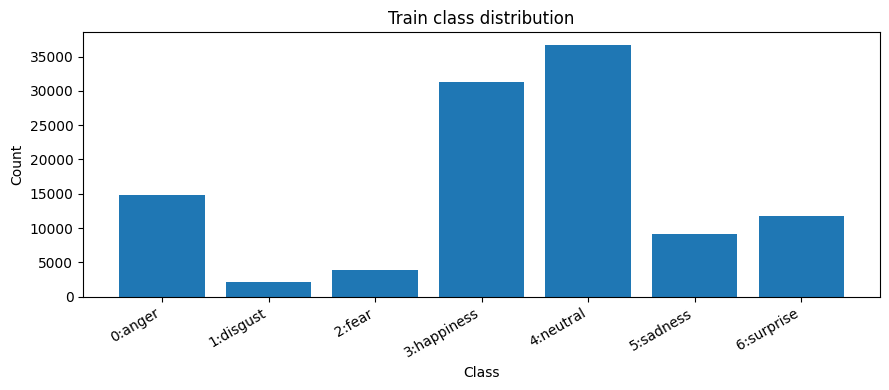

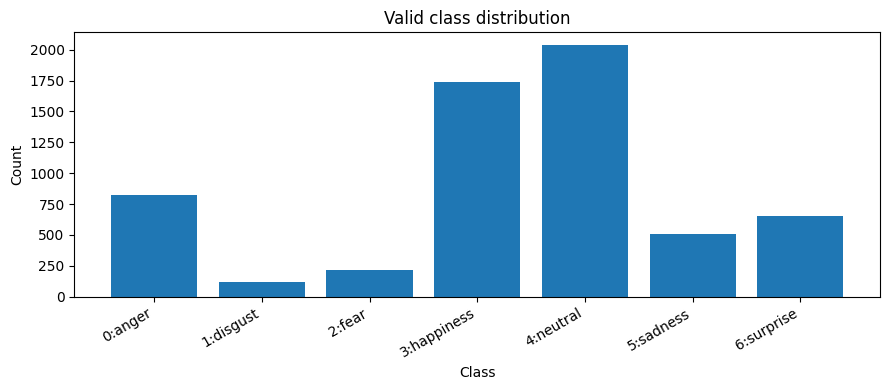

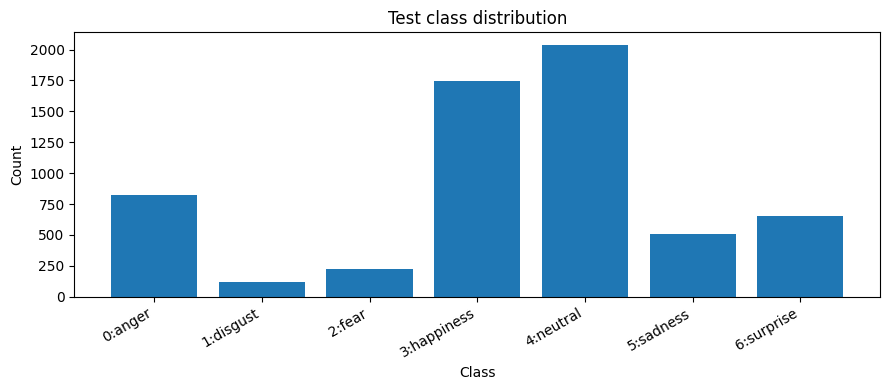

In [23]:
import matplotlib.pyplot as plt

def plot_counts(df, title):
    df = df.sort_values("class_id")
    labels = [f'{i}:{id_to_emotion[i]}' for i in df["class_id"]]
    counts = df["count"].values

    plt.figure(figsize=(9,4))
    plt.bar(labels, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

plot_counts(dist_train, "Train class distribution")
plot_counts(dist_valid, "Valid class distribution")
plot_counts(dist_test,  "Test class distribution")
